In [13]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians
import numpy as np

In [14]:
# import data
links = pd.read_csv("links.csv")
nodes = pd.read_csv("nodes.csv")
loads = pd.read_csv("loads2.csv")

links = links.groupby(['Node1', 'Node2']).sum()

In [15]:
# parameters
loss = 0.05 / 100  # loss per mile (2% per 100mi)
T = 42370  # TIME STEP JAN 1 2010
solar = 1  # amount of solar available

# periods
STEPS = 24

# time steps
TIMES = loads['Time'][:STEPS].values

# nodes to add batteries to

capacity = 200 # capacity in MWh

# method to get distances
def dist(lat1in, lat2in, lon1in, lon2in):
    # approximate radius of earth in miles
    R = 3958.8

    lat1 = radians(lat1in)
    lon1 = radians(lon1in)
    lat2 = radians(lat2in)
    lon2 = radians(lon2in)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [18]:
def cost(batt_nodes):
    # METRICS TO COLLECT
    total_generated = []  # Total generated at each time
    source_generated = []  # Amount generated from each power source by time
    source_limits = []  # Limit from each power source by time
    total_consumed = []  # Total consumed at each time
    power_distance = []  # Power*distance at each time
    objective_value = []  # Total cost: FF Generation + Transmission Loss

    counter = 0

    for T in TIMES:
        # vary solar power
        solar = 1

        # Solar is ON 6am-6pm
        if counter % 24 < 6:
            solar = 0
        elif counter % 24 > 18:
            solar = 0

        # vary wind power
        wind = 1
        # if np.random.uniform() > 0.67:
        #     wind = 0

        # create model
        m = gp.Model("test")
        m.setParam('OutputFlag', 0)

        # create cost function
        cost = gp.LinExpr(0)

        # dictionary of junction (net power) equations at each node
        j = {}

        # create a linear expression at each node
        for i in nodes.index:
            node = nodes['Node'][i]
            j[node] = gp.LinExpr(0)

        # filter to generating nodes
        gens = nodes[nodes['Limit'] > 0]

        # dictionary of generator decision variables
        g = {}

        for i in gens.index:
            # add the decision variable
            node = gens['Node'][i]
            lim = gens['Limit'][i]

            # scale solar
            if gens['Type'][i] == 'Solar':
                lim *= solar

            # scale wind
            if gens['Type'][i] == 'Wind':
                lim *= wind

            g[node] = m.addVar(lb=0, ub=lim)

            # add generation to net power at node
            j[node].add(g[node])

            # add cost to objective
            if gens['Type'][i] == 'Natural Gas':
                cost.add(g[node])

            if gens['Type'][i] == 'Coal':
                cost.add(g[node])

        # FLOWS dictionary indexed by tuple (from, to) pairs
        f = {}

        # distance dictionary indexed by tuple
        d = {}

        # create flow variables
        for i in links.index:
            # index nodes
            n1 = i[0]
            n2 = i[1]

            # create flow (decision) variable in each direction
            f[(n1, n2)] = m.addVar(lb=0, ub=links['Limit'][i])
            f[(n2, n1)] = m.addVar(lb=0, ub=links['Limit'][i])

            # FIND DISTANCE
            lat1 = nodes.loc[nodes['Node'] == n1, 'Latitude'].values[0]
            lat2 = nodes.loc[nodes['Node'] == n2, 'Latitude'].values[0]
            long1 = nodes.loc[nodes['Node'] == n1, 'Longitude'].values[0]
            long2 = nodes.loc[nodes['Node'] == n2, 'Longitude'].values[0]
            distance = dist(lat1, lat2, long1, long2)

            d[(n1, n2)] = distance
            d[(n2, n1)] = distance

            # REMOVED TO NOT DOUBLE COUNT
            # add costs to objective
            # cost.add(f[(n1, n2)], loss * distance)
            # cost.add(f[(n2, n1)], loss * distance)

            # add to junctions (net power balance)
            j[n1].add(f[(n1, n2)], -1)
            j[n1].add(f[(n2, n1)], (1 - loss * distance))
            j[n2].add(f[(n1, n2)], (1 - loss * distance))
            j[n2].add(f[(n2, n1)], -1)

        # LOADS
        t_loads = loads.loc[loads['Time'] == T]
        t_loads = t_loads.drop(columns=['Time', 'Net'])

        # add to junction sets
        for col in t_loads:
            j[int(col)].add(-1 * t_loads[col].values[0])

        # BATTERY
        for batt_node in batt_nodes:

            # Base state is discharging over 16 hours
            j[batt_node].add(gp.LinExpr((capacity / 16)))

            # Charge before 7 and after 22
            if counter % 24 < 7:
                j[batt_node].add(gp.LinExpr(-1 * (capacity / 8)))
            elif counter % 24 > 22:
                j[batt_node].add(gp.LinExpr(-1 * (capacity / 8)))

        # Constraints
        c = {}

        for i in nodes.index:
            node = nodes['Node'][i]
            c[node] = m.addConstr(j[node] == 0)

        # Objective
        obj = m.setObjective(cost, GRB.MINIMIZE)

        # Optimize
        m.optimize()

        # Generation Metrics
        usage = {'Coal': 0, 'Natural Gas': 0, 'Nuclear': 0, 'Hydro': 0, 'Wind': 0, 'Solar': 0}
        limit = {'Coal': 0, 'Natural Gas': 0, 'Nuclear': 0, 'Hydro': 0, 'Wind': 0, 'Solar': 0}

        for i in gens.index:
            node = gens['Node'][i]
            usage[gens['Type'][i]] += g[node].getAttr("x")
            limit[gens['Type'][i]] += g[node].getAttr("UB")

        source_generated.append(usage)
        source_limits.append(limit)

        tot_gen = sum(usage[i] for i in usage)
        total_generated.append(tot_gen)

        # print("\n-----\n")
        # print("Time: %.2f  (%d/%d) " % (T, (counter + 1), STEPS))
        # print("\nGeneration")
        # for i in usage:
        # print("%s: \t %.2f of total (%0.2f of capacity)" % (i, usage[i] / tot_gen, usage[i] / (limit[i] + 1)))

        # Flow Metrics
        # Total Efficiency
        # print("\nTransmission")
        # print("Overall Efficiency: %.4f" % (loads.loc[loads['Time'] == T]['Net'].values[0] / tot_gen))

        total_consumed.append(loads.loc[loads['Time'] == T]['Net'].values[0])

        # Average Distance Traveled
        powdist = sum((f[i].getAttr("x") * d[i]) for i in f)
        # print("Average Distance: %.2f" % (powdist / tot_gen))

        power_distance.append(powdist)

        # print node with highest usage
        # print(int(t_loads.idxmax(axis=1).values[0]))

        counter += 1

    # output plots
    x_axis = range(STEPS)
    #
    # plt.plot(x_axis, total_generated)
    # plt.plot(x_axis, total_consumed)
    # plt.show()
    #
    # plt.close()
    # plt.plot(x_axis, [power_distance[i]/total_generated[i] for i in range(STEPS)])
    # plt.show()
    #
    # plt.close()
    # plt.plot(x_axis, [source_generated[i]['Natural Gas'] for i in range(STEPS)])
    # plt.show()

    # print total FF generation
    lng = sum([source_generated[i]['Natural Gas'] for i in range(STEPS)])
    coal = sum([source_generated[i]['Coal'] for i in range(STEPS)])

    y_axis = [(source_generated[i]['Natural Gas'] + source_generated[i]['Coal']) for i in range(STEPS)]

    plt.plot(x_axis, y_axis, label = str(batt_nodes))

    if len(batt_nodes)>0:
        print("Battery: %.2f MWh" % (lng + coal))
    else:
        print("Base: %.2f MWh" % (lng + coal))
    return lng+coal

Battery: 521523.58 MWh
Battery: 521556.80 MWh
Battery: 522229.29 MWh
Battery: 521513.52 MWh


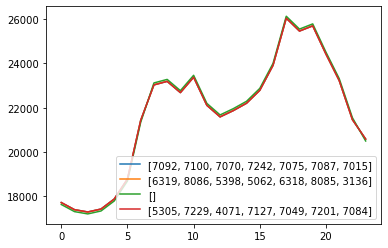

In [8]:
# No batteries
batt_nodes0 = []

# Batteries with highest peak loads
batt_nodes1 = [5305, 7229, 4071, 7127, 7049, 7201, 7084]

# Batteries with highest centralities, ignoring duplicates
batt_nodes2 = [7092, 7100, 7070, 7242, 7075, 7087, 7015]

# Batteries with highest centralities, weighting duplicates at 1000
batt_nodes3 = [6319, 8086, 5398, 5062, 6318, 8085, 3136]

# Batteries with lowest centralities
batt_nodes4 = [[1003, 1015, 1034, 1036, 1064, 2001, 2011]]

for batt in [batt_nodes0, batt_nodes1, batt_nodes2, batt_nodes3, batt_nodes4]:
    try:
        cost(batt)
    except:
        print("Infeasible")

plt.legend()
plt.show()

# Monte Carlo random battery locations

Battery: 521614.13 MWh
Battery: 521530.21 MWh
Battery: 521535.91 MWh
Battery: 521531.08 MWh
Battery: 521538.98 MWh
Battery: 521527.22 MWh
Battery: 521532.15 MWh
Battery: 521534.19 MWh
Battery: 521517.84 MWh
Battery: 521520.81 MWh


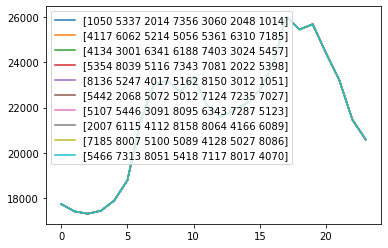

In [11]:
averagecost = 0
num_simulations = 10

for i in range(num_simulations):
    # Generate 7 random battery locations 
    batt = np.random.choice(nodes['Node'], 7)
    try:
        averagecost += cost(batt)
    except:
        print("Failed")
averagecost /= num_simulations
print(averagecost)
        
plt.legend()
plt.show()